Online Retail is Transnational dataset which contains the transactions for UK based registered non- Store online retail. The main Objective is to find the number of segments that are  possibly available to target and also segmenting them accordingly.

### 1. Data Preparation:

#### 1.1 Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [54]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
pd.set_option("display.max_columns", 500)

#### 1.2 Importing Dataset:

In [4]:
df = pd.read_csv("Online+Retail.csv", encoding="unicode_escape")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
df.shape

(541909, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### 1.3 Data Cleaning:

In [7]:
# missing values:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
((df.isnull().sum())/len(df)) * 100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [9]:
# drop all rows having missing values:
df  = df.dropna()

In [10]:
((df.isnull().sum())/len(df)) * 100

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

#### 1.4 Preparation of RFM attributes:

- RFM Analysis:
- R - Recency (no of days since last purchase)
- F - Frequency (no of transactions)
- M - Monetary Value (Total amountof transactions) - Revenue contributed

In [11]:
# cols = cust id, recency, frequency, Monetary value

In [12]:
# new column : amount
df["Amount"] = df["Quantity"] * df["UnitPrice"]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [13]:
# monetary value:
df_Amount=df.groupby("CustomerID")["Amount"].sum()
df_Amount = df_Amount.reset_index()
df_Amount.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [14]:
# frequency:
df_frequency = df.groupby("CustomerID")["InvoiceNo"].count()
df_frequency = df_frequency.reset_index()
df_frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [15]:
df_frequency.columns = ["CustomerID", "Frequency"]

In [16]:
df_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [17]:
# merging the Dataframes:
df_group = pd.merge(df_Amount,df_frequency,on="CustomerID",how="inner")
df_group.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [18]:
# recency:
# convert to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format ="%d-%m-%Y %H:%M")

In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [21]:
#compute max date:
max_date = max(df["InvoiceDate"])
max_date

Timestamp('2011-12-09 12:50:00')

In [22]:
# compute the difference between max date and invoice date:
df["Diff"] = max_date - df["InvoiceDate"]

In [23]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [24]:
# creating recency column:
last_purchase = df.groupby("CustomerID")["Diff"].min()
last_purchase.head()

CustomerID
12346.0   325 days 02:33:00
12347.0     1 days 20:58:00
12348.0    74 days 23:37:00
12349.0    18 days 02:59:00
12350.0   309 days 20:49:00
Name: Diff, dtype: timedelta64[ns]

In [25]:
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [26]:
# merging the dataframes:
df_group = pd.merge(df_group, last_purchase, on = "CustomerID", how = "inner")
df_group.head()

,CustomerID,Amount,Frequency,Diff
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [27]:
df_group.columns = ["CustomerID", "Amount", "Frequency", "Recency"]

In [28]:
df_group.head(10)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00
5,12352.0,1545.41,95,35 days 22:13:00
6,12353.0,89.00,4,203 days 19:03:00
7,12354.0,1079.40,58,231 days 23:39:00
8,12355.0,459.40,13,213 days 23:01:00
9,12356.0,2811.43,59,22 days 04:10:00


In [29]:
import datetime as dt

In [30]:
# number of days required:
df_group["Recency"] = df_group["Recency"].dt.days
df_group["Recency"].head()

0    325
1      1
2     74
3     18
4    309
Name: Recency, dtype: int64

#### 1.5 Outlier Treatment:

<AxesSubplot:xlabel='Amount'>

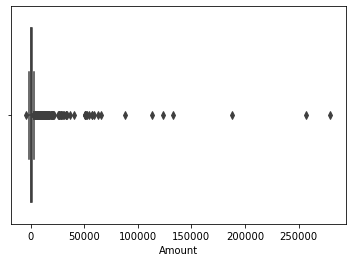

In [31]:
sns.boxplot(df_group["Amount"])

<AxesSubplot:xlabel='Frequency'>

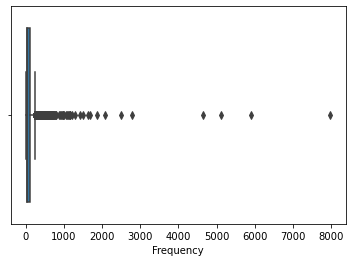

In [32]:
sns.boxplot(df_group["Frequency"])

<AxesSubplot:xlabel='Recency'>

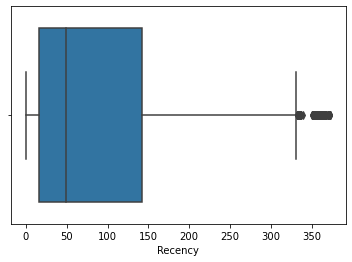

In [33]:
sns.boxplot(df_group["Recency"])

In [34]:
# removing Statistical outliers:
q1 = df_group.Amount.quantile(0.05)
q3 = df_group.Amount.quantile(0.95)
IQR = q3 - q1
df_group = df_group[(df_group.Amount >=q1 - 1.5* IQR )&(df_group.Amount<=q3+1.5*IQR)]

q1 = df_group.Recency.quantile(0.05)
q3 = df_group.Recency.quantile(0.95)
IQR = q3 - q1
df_group = df_group[(df_group.Recency >=q1 - 1.5* IQR )&(df_group.Recency<=q3+1.5*IQR)]

q1 = df_group.Frequency.quantile(0.05)
q3 = df_group.Frequency.quantile(0.95)
IQR = q3 - q1
df_group = df_group[(df_group.Frequency >=q1 - 1.5* IQR )&(df_group.Frequency<=q3+1.5*IQR)]

#### 1.6 Rescaling

In [35]:
df_rfm = df_group[["Amount", "Frequency", "Recency"]]
df_rfm

,Amount,Frequency,Recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309
...,...,...,...
4366,173.90,9,73
4367,180.60,10,277
4368,80.82,7,180
4369,176.60,13,7


In [36]:
# standard Scaling:
#instantiate:
scaler = StandardScaler()
#fit_transform:
df_rfm_scaled = scaler.fit_transform(df_rfm)
df_rfm_scaled.shape

(4293, 3)

In [37]:
df_rfm_scaled = pd.DataFrame(df_rfm_scaled)
df_rfm_scaled.columns = ["Amount", "Frequency", "Recency"]
df_rfm_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


#### 1.7 Hopkins Statistics:

In [38]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

### 2. Modelling:

#### Hierachical Clustering:


In [55]:
df_group.head()

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


In [56]:
df_rfm_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


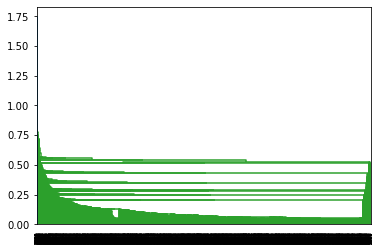

In [58]:
# single linkage:
mergings = linkage(df_rfm_scaled,method="single", metric = "euclidean")
dendrogram(mergings)
plt.show()

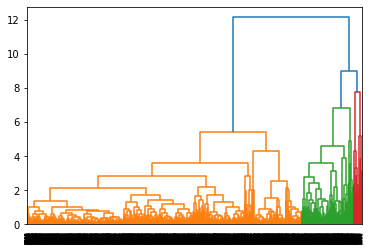

In [59]:
# Complete Linkage:
mergings = linkage(df_rfm_scaled,method="complete", metric = "euclidean")
dendrogram(mergings)
plt.show()

In [60]:
cut_tree(mergings,n_clusters=3)

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [61]:
cluster_labels = cut_tree(mergings,n_clusters=3).reshape(-1,)

In [62]:
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [63]:
# Assign Cluster labels:
df_group["cluster_labe"] = cluster_labels

In [64]:
df_group.head()

,CustomerID,Amount,Frequency,Recency,ClusterID,cluster_labe
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,2,1
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,0,0


<AxesSubplot:xlabel='cluster_labe', ylabel='Amount'>

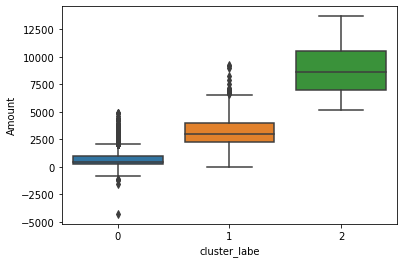

In [67]:
#plot:
sns.boxplot(x="cluster_labe", y = "Amount", data=df_group)

<AxesSubplot:xlabel='cluster_labe', ylabel='Recency'>

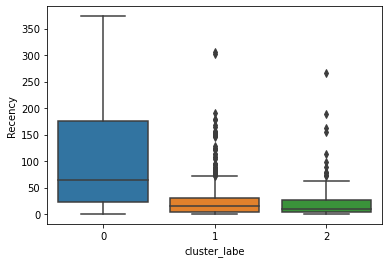

In [68]:
#plot:
sns.boxplot(x="cluster_labe", y = "Recency", data=df_group)

<AxesSubplot:xlabel='cluster_labe', ylabel='Frequency'>

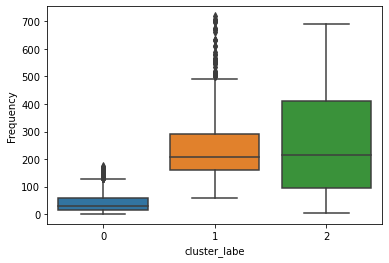

In [69]:
#plot:
sns.boxplot(x="cluster_labe", y = "Frequency", data=df_group)

#### Conclusion:

Customers segmented under Cluster Label 2 are Active Customers interms of Amount, Recency and Frequency where as Customers under Cluster Label 1 and 3 are almost showing same similarities in Recency and Frequency.